<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# 2021 NASA Harvest Rwanda Baseline Model



### Dependencies



In [ ]:
!pip install radiant-mlhub
!pip install segmentation_models
!pip install rasterio
!pip install ipywidgets
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 672.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.0
    Uninstalling shapely-2.0.0:
      Successfully uninstalled shapely-2.0.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.4
    Uninstalling pyda

In [ ]:
# Importing the needed libraries
import getpass
import glob
import keras
import os
import pickle
import random
from radiant_mlhub import Dataset

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import pandas as pd
import rasterio as rio

import tensorflow as tf
import segmentation_models as sm
from segmentation_models import Unet,PSPNet,FPN,Linknet

from pathlib import Path
from random import choice
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.models import load_model
from keras.optimizers import *
from keras.preprocessing import image

from tensorflow.keras.layers import *
from tensorflow.keras.losses import *

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint,CSVLogger,LearningRateScheduler
import tensorflow as tf


from sklearn.model_selection import train_test_split

from typing import List, Any, Callable, Tuple
from scipy import stats
import cv2

from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
import random
from segmentation_models.utils import set_trainable
import gc
from tqdm import tqdm
from sklearn.model_selection import KFold
from tensorflow_addons.layers import GroupNormalization
import collections
import keras_applications as ka

Segmentation Models: using `keras` framework.


In [ ]:
tf.config.list_physical_devices("GPU") #activate GPU resource for model training

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
dataset_id = 'nasa_rwanda_field_boundary_competition'
assets = ['labels']

In [ ]:
#ea18cf1fd9c1c906c461aab909ef7c12f0e553e0d0062ac0e5d9d79d6ecd98fa

In [ ]:
#Append your MLHUB_API_KEY after this cell is executed to download dataset
os.environ['MLHUB_API_KEY'] =  'ea18cf1fd9c1c906c461aab909ef7c12f0e553e0d0062ac0e5d9d79d6ecd98fa' #getpass.getpass(prompt="MLHub API Key: ")
dataset = Dataset.fetch(dataset_id)

In [ ]:
dataset.download(if_exists='overwrite')

nasa_rwanda_field_boundary_competition: fetch stac catalog: 160KB [00:00, 228.81KB/s]                         
download assets: 100%|██████████| 1738/1738 [06:21<00:00,  4.56it/s]


In [ ]:
save_url = '/content/drive/MyDrive/NASA'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mv '/content/nasa_rwanda_field_boundary_competition' '/content/drive/MyDrive/NASA'

We have two sets of data: the train and test dataset, each having a list of file ids belonging to them.
For model development purposes, we will use the training set(`train_tiles`) and use the test set for model prediction/evaluation.

In [ ]:
train_source_items = f"/content/{dataset_id}/{dataset_id}_source_train"
train_label_items = f"/content/{dataset_id}/{dataset_id}_labels_train"

In [ ]:
def clean_string(s: str) -> str:
    """
    extract the tile id and timestamp from a source image folder
    e.g extract 'ID_YYYY_MM' from 'nasa_rwanda_field_boundary_competition_source_train_ID_YYYY_MM'
    """
    s = s.replace(f"{dataset_id}_source_", '').split('_')[1:]
    return '_'.join(s)

In [ ]:
train_tiles = [clean_string(s) for s in next(os.walk(train_source_items))[1]]

In [ ]:
train_id = list(set([s.split('_')[0] for s in train_tiles]))

In [ ]:
train_month = list(set([s.split('_')[1] +'_'+ s.split('_')[2] for s in train_tiles]))

Our source images have pixel values > 255, hence we need to apply normalisation on our images to generate a normalised image. We apply the min-max normalisation for this which is simply: $${\text{all pixel values - minimum pixel value} \over \text{maximum pixel value - minimum pixel value}}$$

In [ ]:
def normalize(
    array: np.ndarray
):
    """ normalise image to give a meaningful output """
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

### Data Augmentation

In this notebook, we will perform data augmentation on our normalised images. This will be used to populate the model with data to obtain even more accurate results.

We will employ the following data augmentation techniques on the dataset:
- rotation, flipping, blurring.


In [ ]:
def load_images(id):
  images = np.zeros((6,256,256,4))
  for idx,month in enumerate(train_month):
    bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{id}_{month}/B01.tif")
    bd1_array = bd1.read(1)
    bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{id}_{month}/B02.tif")
    bd2_array = bd2.read(1)
    bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{id}_{month}/B03.tif")
    bd3_array = bd3.read(1)
    bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{id}_{month}/B04.tif")
    bd4_array = bd4.read(1)
    b01_norm = normalize(bd1_array)
    b02_norm = normalize(bd2_array)
    b03_norm = normalize(bd3_array)
    b04_norm = normalize(bd4_array)
    field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
    images[idx] = field
  mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{id}/raster_labels.tif").read(1)
  (thresh, blackAndWhiteMask) = cv2.threshold(mask, 100, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  return images[:,:,:,0:3],blackAndWhiteMask

In [ ]:
def t_linear(
    field: np.ndarray,
    mask: np.ndarray,
    _: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Apply a linear (i.e. no) transformation and save."""
    return field, mask

def t_rotation(
    field: np.ndarray,
    mask: np.ndarray,
    rot: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate the data."""
    assert rot in range(0, 3 + 1)
    for _ in range(rot):
        field = np.rot90(field)
        mask = np.rot90(mask)
    return field, mask

def t_flip(
    field: np.ndarray,
    mask: np.ndarray,
    idx: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Flip the data."""
    assert idx in range(0, 2 + 1)
    if idx == 0:  # Diagonal
        field = np.rot90(np.fliplr(field))
        mask = np.rot90(np.fliplr(mask))
    if idx == 1:  # Horizontal
        field = np.flip(field, axis=0)
        mask = np.flip(mask, axis=0)
    if idx == 2:  # Vertical
        field = np.flip(field, axis=1)
        mask = np.flip(mask, axis=1)
    return field, mask

def t_blur(
    field: np.ndarray,
    mask: np.ndarray,
    sigma: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Blur the image by applying a Gaussian filter."""
    assert 0 <= sigma <= 10
    sigma_f = 1.0 + (sigma / 10)
    field = np.copy(field)
    for i in range(field.shape[2]):
        field[:, :, i] = gaussian_filter(field[:, :, i], sigma=sigma_f)
    return field, mask

def t_noise(field: np.ndarray,
    mask: np.ndarray,
    sigma:float
    )-> Tuple[np.ndarray, np.ndarray]:
    return random_noise(field,var=sigma**2),mask

def t_translation(field: np.ndarray,
    mask: np.ndarray,
    range:int
    )-> Tuple[np.ndarray, np.ndarray]:

    translation_range = np.random.randint(0,range,2)

    transform = AffineTransform(translation=(translation_range[0],translation_range[1]))
    wrapShift_image = warp(field,transform,mode='wrap')
    wrapShift_mask = warp(mask,transform,mode='wrap')

    return wrapShift_image,wrapShift_mask


def t_random_crop(field: np.ndarray,
    mask: np.ndarray, crop_size:Tuple[int,int])-> Tuple[np.ndarray, np.ndarray]:
    h, w,_  = field.shape

    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    field = field[top:bottom, left:right]
    mask = mask[top:bottom, left:right]
    return field,mask

def scale_augmentation(field: np.ndarray,
    mask: np.ndarray,scale_range, crop_size):
    scale_size = np.random.randint(crop_size+1,scale_range)

    field = cv2.resize(field, (scale_size, scale_size))
    mask = cv2.resize(mask, (scale_size, scale_size))

    field,mask = t_random_crop(field,mask, (crop_size,crop_size))
    return  field,mask



def get_filter(size,color_idxs):
    filter = np.zeros((size,size,3))
    if color_idxs!=-1:
      filter[:,:,color_idxs] = np.ones((size,size,len(color_idxs)))
    return filter

def add_filter(field,mask):
    size = field.shape[0]

    red_filter = get_filter(size,[0])
    green_filter = get_filter(size,[1])
    white_filter = get_filter(size,[0,1,2])
    black_filter = get_filter(size,-1)

    filters = [red_filter,green_filter,white_filter,black_filter]
    alpha = np.random.uniform(0.25,0.5)
    filter_idx = np.random.randint(0,4)
    output_rgba = field.copy()
    filterd_image = output_rgba[:,:,0:3].copy()
    filterd_image_ =  cv2.addWeighted(filters[filter_idx], alpha, filterd_image, 1 - alpha,0, filterd_image)

    return filterd_image_,mask

In [ ]:
def show_image(field:np.ndarray, mask:np.ndarray):
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field[:,:,0:3])  # rgb band
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_6months_images(id):
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(8*2, 6*3))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(2, 3),
                    axes_pad=0.1,  #
                    )
    images,mask = load_images(id)
    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im[:,:,0:3])
    plt.show()

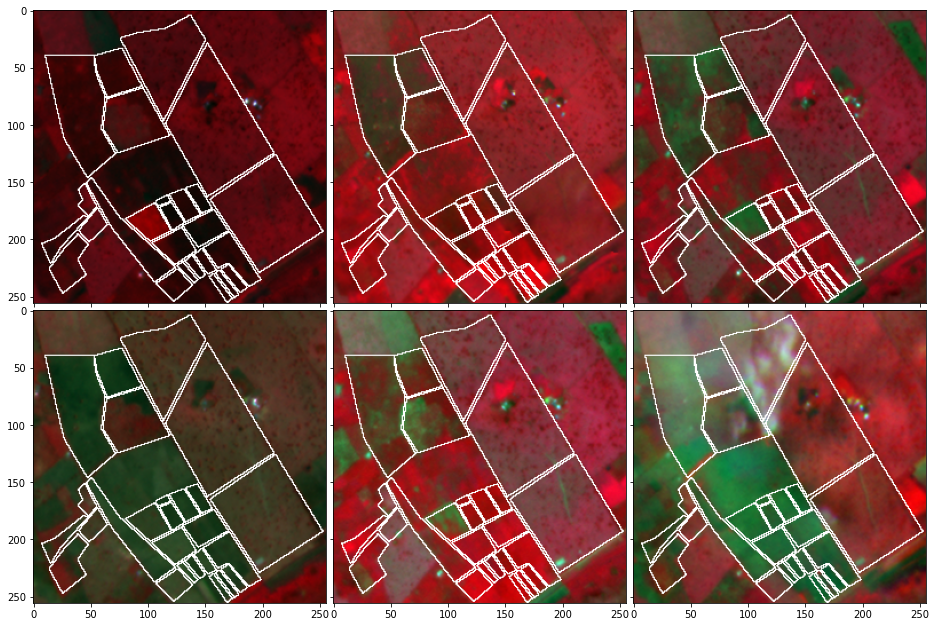

In [ ]:
show_6months_images('50')

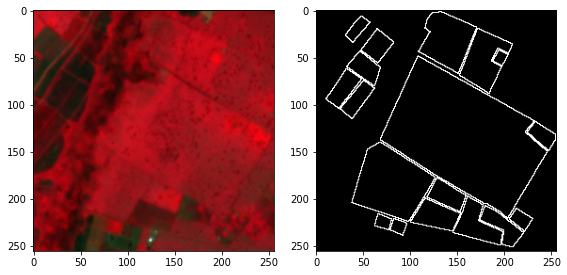

In [ ]:
show_image(field, mask)

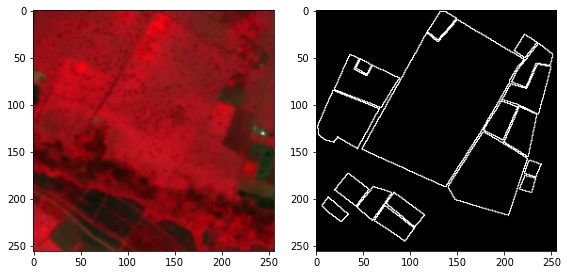

In [ ]:
f,m = t_rotation(field, mask, rot=1) #rotation
show_image(f,m)

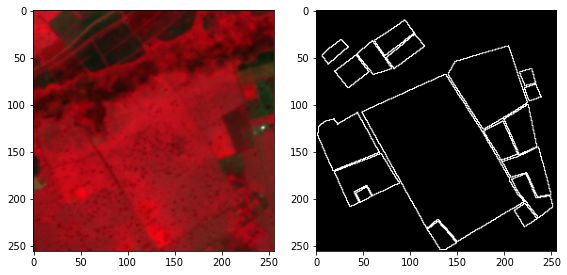

In [ ]:
f,m = t_flip(field, mask, idx=0) #flipping
show_image(f,m)

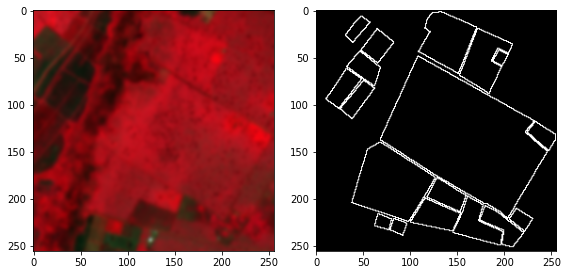

In [ ]:
f,m = t_blur(field, mask, sigma=5) #blur
show_image(f,m)

In [ ]:
def resize(field,mask,size=240):
    field = cv2.resize(field, (size, size))
    mask = cv2.resize(mask, (size,size))
    return field,mask

In [ ]:
def standardize(X:np.ndarray,axis):
    return (X - X.mean(axis=axis,keepdims=True))/(X.std(axis=axis,keepdims=True) +1e-9)

In [ ]:
xp = [0, 60,80, 128, 192, 255]
fp = [0, 7, 15,128, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')
def contrast_stretching(img):
  img = cv2.LUT(img, table)
  return img

In [ ]:
def to_rgb_uint8(field):
  return (field[:,:,0:3]*255).astype(np.uint8)

In [ ]:
def apply_brightness_contrast(input_img, brightness = 265, contrast = 150):
    brightness = map(brightness, 0, 510, -255, 255)
    contrast = map(contrast, 0, 254, -127, 127)

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

def map(x, in_min, in_max, out_min, out_max):
    return int((x-in_min) * (out_max-out_min) / (in_max-in_min) + out_min)


def adaptive_gray_brightness(gray_image:np.ndarray,alpha,beta):

    rgb = cv2.cvtColor((gray_image*255).astype(np.uint8),cv2.COLOR_GRAY2RGB)
    hsv = cv2.cvtColor(rgb,cv2.COLOR_RGB2HSV)

    (h,s,v) = cv2.split(hsv)
    dif = v.sum()- alpha
    if dif < 0 :

      v = cv2.add(v,abs(dif)//beta)
      v[v>255] = 255
      v[v<0] = 0

    hsv = cv2.merge((h,s,v))
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    gray = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)
    return gray

In [ ]:
def generate():

    train_ids,test_ids = train_test_split(np.array(train_id), test_size=0.15, random_state=22,shuffle=True)
    images,masks = [],[]


    for image_id in  tqdm(train_ids):
        field,mask = load_images(image_id)
        for idx in range(len(field)):
          rgba_image = field[idx]

          if IMG_WIDTH != 256:
            rgba_image,mask = resize(rgba_image,mask,IMG_WIDTH)


          f1,m1 = t_linear(rgba_image,mask)

          images.append(f1)
          masks.append(m1)


          f2,m2 = t_rotation(rgba_image, mask, rot=1)
          images.append(f2)
          masks.append(m2)


          f3,m3 = t_rotation(rgba_image, mask, rot=2)
          images.append(f3)
          masks.append(m3)


          f4,m4 = t_flip(rgba_image, mask, idx=1)
          images.append(f4)
          masks.append(m4)

          f5,m5 = t_flip(rgba_image, mask, idx=2)
          images.append(f5)
          masks.append(m5)


          f8,m8 = scale_augmentation(rgba_image,mask,IMG_WIDTH+50,IMG_WIDTH)
          images.append(f8)
          masks.append(m8)


    X_train,y_train = np.zeros((len(images),IMG_WIDTH,IMG_WIDTH,IMG_CHANNELS)),np.zeros((len(masks),IMG_WIDTH,IMG_WIDTH))
    X_test,y_test = np.zeros((len(test_ids),6,IMG_WIDTH,IMG_WIDTH,IMG_CHANNELS)),np.zeros((len(test_ids),IMG_WIDTH,IMG_WIDTH))

    for idx,(image,mask) in enumerate(zip(images,masks)):

        rgb = to_rgb_uint8(image)
        rgb = apply_brightness_contrast(rgb,265,150)


        X_train[idx] = standardize(rgb/255.0,(0,1))
        y_train[idx] = mask



    for idx,image_id in enumerate(test_ids):
        field,mask = load_images(image_id)
        x_field = np.zeros((6,IMG_WIDTH,IMG_WIDTH,IMG_CHANNELS))
        for i in range(len(field)):
              rgba_image = field[i]
              if IMG_WIDTH != 256:
                  rgba_image,mask = resize(rgba_image,mask,IMG_WIDTH)

              rgb = to_rgb_uint8(rgba_image)
              rgb = apply_brightness_contrast(rgb,265,150)

              x_field[i] = standardize(rgb/255.0,(0,1))

        X_test[idx] = x_field
        y_test[idx] = mask

    return X_train,y_train,X_test,y_test

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [ ]:
random.seed(30)
np.random.seed(31)
tf.random.set_seed(32)
try:
  X_train,y_train,X_test,y_test = generate()
except Exception as e:
  print(e)

100%|██████████| 48/48 [00:03<00:00, 12.22it/s]


In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1728, 256, 256, 3) (1728, 256, 256)
(9, 6, 256, 256, 3) (9, 256, 256)


In [ ]:
gc.collect()
X_train,y_train = shuffle(X_train,y_train,random_state=35)
gc.collect()

0

### Model Training

We decided to use U-Net as it has shown impressive results over multiple domains in image segmentation.
We will employ a ResNet34 backbone with our spatio-temporal U-Net model.

We will  use an 80:20 train:validation set split for model training.

Since this is a binary segmentation problem (field boundary or no field boundary), we will use the `binary cross_entropy` loss.

In [ ]:
num_channels = 3
input_shape = (IMG_WIDTH,IMG_WIDTH,num_channels)

For the model, we will make use of two key metrics: **Recall** and **F1-score**.

**Recall** evaluates how much of the field boundaries which were labelled were actually predicted as well while the **f1-score** combines the precision and recall by evaluating the harmonic mean.

**NOTE** that the recall is the more important metric for this case as we are mostly concerned about the retrieved field boundaries out of the labelled field boundaries.

In [ ]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def f1(y_true, y_pred):
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall_   = recall(y_true, y_pred)
    return 2*((precision*recall_)/(precision+recall_+K.epsilon()))

In [ ]:
def soft_dice_loss(y_true, y_pred):

    axis=(0,1)
    epsilon=0.00001

    dice_numerator = 2 * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator/dice_denominator)

    return dice_loss

In [ ]:
def IoU_loss(y_true, y_pred):

  def IoU_coef(y_true, y_pred):

    T = K.flatten(y_true)
    P = K.flatten(y_pred)

    intersection = K.sum(T * P)
    epsilon=0.00001

    IoU = intersection / (K.sum(T) + K.sum(P) - intersection) + epsilon
    return IoU

  return -IoU_coef(y_true, y_pred)

In [ ]:
class WSConv2D(tf.keras.layers.Conv2D):
    def __init__(self, *args, **kwargs):
        super(WSConv2D, self).__init__(*args, **kwargs)

    def standardize_weight(self, weight):

        mean = tf.math.reduce_mean(weight, axis=(0, 1, 2), keepdims=True)
        std = tf.math.reduce_std(weight, axis=(0, 1, 2), keepdims=True)

        return (weight - mean)/(std + tf.keras.backend.epsilon())

    def call(self, inputs):
        self.kernel.assign(self.standardize_weight(self.kernel))
        return super().call(inputs)

In [ ]:
def unet(pretrained_weights = None,input_size = input_shape,n_group_norm=32):
    inputs = Input(input_size)
    conv1 = WSConv2D(64, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = GroupNormalization(n_group_norm)(conv1)
    conv1 =  WSConv2D(64, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = GroupNormalization(n_group_norm,)(conv1)



    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 =  WSConv2D(128, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = GroupNormalization(n_group_norm)(conv2)
    conv2 =  WSConv2D(128, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = GroupNormalization(n_group_norm)(conv2)


    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 =  WSConv2D(256, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = GroupNormalization(n_group_norm)(conv3)
    conv3 =  WSConv2D(256, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = GroupNormalization(n_group_norm)(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 =  WSConv2D(512, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = GroupNormalization(n_group_norm)(conv4)
    conv4 =  WSConv2D(512, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = GroupNormalization(n_group_norm)(conv4)

    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 =  WSConv2D(1024, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = GroupNormalization(n_group_norm)(conv5)
    conv5 =  WSConv2D(1024, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = GroupNormalization(n_group_norm)(conv5)

    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)

    conv6 =  WSConv2D(512, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = GroupNormalization(n_group_norm)(conv6)
    conv6 =  WSConv2D(512, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = GroupNormalization(n_group_norm)(conv6)


    up7 = Conv2D(256, 2, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)

    conv7 =  WSConv2D(256, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = GroupNormalization(n_group_norm)(conv7)
    conv7 =  WSConv2D(256, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = GroupNormalization(n_group_norm)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)

    conv8 =  WSConv2D(128, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = GroupNormalization(n_group_norm)(conv8)
    conv8 =  WSConv2D(128, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = GroupNormalization(n_group_norm)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)

    conv9 =  WSConv2D(64, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 =  WSConv2D(64, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 =  WSConv2D(2, 3, activation = 'relu',use_bias=False, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = GroupNormalization(2)(conv9)
    conv10 = WSConv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])
    return model

In [ ]:
resnet50 = Unet('resnet50',input_shape=input_shape,decoder_use_batchnorm=True)
seresnext50 = Unet('seresnext50',input_shape=input_shape,decoder_use_batchnorm=True)
densenet169 = Unet('densenet169',input_shape=input_shape,decoder_use_batchnorm=True)
efficientnetb0 =  Unet('efficientnetb0',input_shape=input_shape,decoder_use_batchnorm=True)
efficientnetb4 =  Unet('efficientnetb4',input_shape=input_shape,decoder_use_batchnorm=True)
inceptionresnetv2 = Unet('inceptionresnetv2',input_shape=input_shape,decoder_use_batchnorm=True)
ws_conv = unet()

219055592/219055592 [==============================] - 58s 0us/step


In [ ]:
model = ws_conv

In [ ]:
BACKBONE = 'WS_CONV_10'
checkpoint_filepath = save_url + '/'+ f'{BACKBONE}_({i})_'+'unet_weights.{epoch:02d}-{val_f1:.2f}.hdf5'
logger = CSVLogger(save_url + '/'+ f'{BACKBONE}_({i})_'+'unet_logs.csv',append=True)
unet_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
model.compile(optimizer = Adam(), loss = soft_dice_loss, metrics=[f1])
batch_size = 4
model.optimizer.learning_rate = 0.1 * batch_size/32
gc.collect()
model.fit(X_train, y_train,validation_split=0.2,shuffle=False,
                    callbacks=[unet_checkpoint_callback,logger,reduce_lr,early_stop],
                    batch_size=batch_size, epochs=30,initial_epoch=0,verbose=0)
gc.collect()

In [ ]:
import pandas as pd

In [ ]:
plt.figure(figsize=(10,10))
logfile = save_url + '/'+ f'{BACKBONE}_({i})_'+'unet_logs.csv'
logs = pd.read_csv(logfile)
plt.plot(logs['loss'],label=f'{i}_l')
plt.plot(logs['val_loss'],label=f'{i}_v')
plt.legend()

In [ ]:
test_preds = np.zeros((9,IMG_HEIGHT, IMG_WIDTH))
for idx in range(len(X_test)):
  model_preds = np.empty((6,6,IMG_HEIGHT, IMG_WIDTH))
  for i in range(6):
    new_model = models[i]
    new_model.load_weights(weights[i])
    for c in range(6):
       model_pred = new_model.predict((X_test[idx,c]).reshape(1,256,256,3))
       model_pred = model_pred.reshape(IMG_HEIGHT, IMG_WIDTH)
       model_preds[i,c] = model_pred

  model_pred = np.mean(model_preds,axis=(0,1))
  model_pred = (model_pred >= 0.5).astype(np.uint8)
  test_preds[idx]= model_pred

In [ ]:
f1(y_test,test_preds)

### Loading test chips to run predictions

In [ ]:
test_source_items = f"/content/{dataset_id}/{dataset_id}_source_test"
test_tiles = [clean_string(s) for s in next(os.walk(test_source_items))[1]]

In [ ]:
test_tile_ids = set()
for tile in test_tiles:
    test_tile_ids.add(tile.split('_')[0])

In [ ]:
X_test_zindi = np.empty((len(test_tile_ids),6, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
i = 0
loaded_tiles = []
for tile_id in test_tile_ids:
    idx = 0
    for timestamp in train_month:
        bd1 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B01.tif")
        bd1_array = bd1.read(1)
        bd2 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B02.tif")
        bd2_array = bd2.read(1)
        bd3 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B03.tif")
        bd3_array = bd3.read(1)
        bd4 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B04.tif")
        bd4_array = bd4.read(1)
        b01_norm = normalize(bd1_array)
        b02_norm = normalize(bd2_array)
        b03_norm = normalize(bd3_array)
        b04_norm = normalize(bd4_array)

        field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
        rgb = to_rgb_uint8(field)
        rgb = apply_brightness_contrast(rgb,265,150)

        X_test_zindi[i,idx,:,:,:] = rgb/255.0



        idx+=1
    i+=1
    loaded_tiles.append(str(tile_id).zfill(2)) #track order test tiles are loaded into X to make sure tile id matches

In [ ]:
X_test_zindi = standardize(X_test_zindi,(2,3))

In [ ]:
predictions_dictionary = {}
for idx in range(len(test_tile_ids)):
  model_preds = np.empty((6,6,IMG_HEIGHT, IMG_WIDTH))
  for i in range(6):
    new_model = models[i]
    new_model.load_weights(weights[i])
    for c in range(6):
       model_pred = new_model.predict((X_test_zindi[idx,c]).reshape(1,256,256,3))
       model_pred = model_pred.reshape(IMG_HEIGHT, IMG_WIDTH)
       model_preds[i,c] = model_pred

  model_pred = np.mean(model_preds,axis=(0,1))
  model_pred = (model_pred >= 0.5).astype(np.uint8)
  predictions_dictionary.update([(str(loaded_tiles[idx]), pd.DataFrame(model_pred))])

In [ ]:
len(predictions_dictionary)

In [ ]:
dfs = []
for key, value in predictions_dictionary.items():
    ftd = value.unstack().reset_index().rename(columns={'level_0': 'row', 'level_1': 'column', 0: 'label'})
    ftd['tile_row_column'] = f'Tile{key}_' + ftd['row'].astype(str) + '_' + ftd['column'].astype(str)
    ftd = ftd[['tile_row_column', 'label']]
    dfs.append(ftd)
sub = pd.concat(dfs)

In [ ]:
sub.to_csv(f"./harvest_sample_submission_47.csv", index = False)